In [22]:
import os
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import contextily as ctx
from numpy import sqrt
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from logger import ExperimentLogger
from sklearn.ensemble import GradientBoostingRegressor
from logger import ExperimentLogger
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# XGBoost

## Load data

In [23]:
current_dir = os.getcwd()
well_filter = 1

data_path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}_ahn_elevation.csv")
testing_path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}_BEST.csv")

In [24]:
df = pd.read_csv(data_path)
len(df)

7620

In [25]:
df_test_new = pd.read_csv(testing_path)
print(len(df_test_new))

1760


In [26]:
# df['soil region'].unique()

In [27]:
# df = df[~df["soil region"].isin(["loss", "zand", "clay"])]
# len(df)

## Sort by date

In [28]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove columns

In [29]:
df = df.drop(columns=['soil region', 'peattype_1', 'calciccontent_1', 'fedith_1', 'loamcontent_1', 'minimumloamcontent_1', 'minimumsandmedian_1', 'siltcontent_1'])
# df = df.drop(columns=['landuse code'])

df = df.dropna()
len(df)

5341

## Add year and month as features

In [30]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Feature engineering

In [31]:
# def add_neighbor_mean(df, value_col='nitrate', n_neighbors=4):
#     # Make a copy to avoid modifying the original
#     df = df.copy()
#     df['neighbor_mean'] = np.nan
    
#     # Group by year and month
#     for (year, month), group in df.groupby(['year', 'month']):
#         # Use only wells with valid lat/lon and value
#         mask = group[['lon', 'lat', value_col]].notnull().all(axis=1)
#         wells = group[mask]
#         if len(wells) < n_neighbors + 1:
#             continue  # Not enough data
        
#         coords = wells[['lon', 'lat']].values
#         tree = cKDTree(coords)
        
#         # For each well in this (year, month), find nearest neighbors
#         for idx, row in wells.iterrows():
#             # Query for n_neighbors+1 because the first neighbor is itself
#             dists, indices = tree.query([row['lon'], row['lat']], k=n_neighbors+1)
#             # Exclude itself (distance==0)
#             neighbor_indices = indices[1:n_neighbors+1]
#             neighbor_vals = wells.iloc[neighbor_indices][value_col].values
#             mean_val = np.mean(neighbor_vals)
#             df.at[idx, 'neighbor_mean'] = mean_val
    
#     return df

# df = add_neighbor_mean(df, value_col='nitrate', n_neighbors=2)

## Change column type

In [32]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [33]:
df.dtypes

bro-id                                   object
nitrate                                 float64
geometry                                 object
date                        datetime64[ns, UTC]
landuse code                           category
population                              float64
elevation                               float64
lon                                     float64
lat                                     float64
precipitation                           float64
temperature                             float64
n deposition                            float64
mainsoilclassification_1               category
organicmattercontent_1                  float64
density_1                               float64
acidity_1                               float64
minimumacidity_1                        float64
maximumacidity_1                        float64
cnratio_1                               float64
maximumloamcontent_1                    float64
sandmedian_1                            

## Remove nitrate outliers

<Axes: >

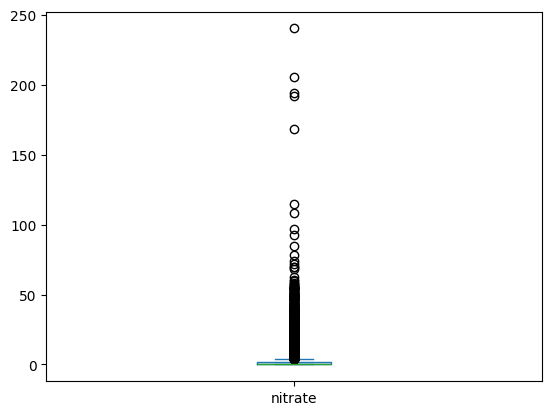

In [34]:
df[["nitrate"]].plot(kind = "box")

## Test / train split

In [35]:
outlier_method = "manual_removal"
top_nitrate_outliers = list(df["nitrate"].sort_values()[-20:].index)
top_nitrate_outliers
df = df.drop(top_nitrate_outliers)
len(df)

5321

In [36]:
# Define the split by year
train_years = list(range(2008, 2021))
test_years = [2021, 2022, 2023]

# Filter datasets
train_df = df[df["year"].isin(train_years)].copy()
test_df = df[df["year"].isin(test_years)].copy()

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 4439
Test: 882


## Outliers

In [37]:
# def get_outlier_mask(s, method='iqr', factor=1.5, z_thresh=3, mad_thresh=3.5, 
#                      lower_pct=0.01, upper_pct=0.99, contamination=0.01, X=None, 
#                      dbscan_eps=0.5, dbscan_min_samples=5, domain_range=None):

#     if method == 'iqr':
#         q1, q3 = s.quantile([0.25, 0.75])
#         iqr = q3 - q1
#         lower, upper = q1 - factor * iqr, q3 + factor * iqr
#         return (s >= lower) & (s <= upper)

#     elif method == 'zscore':
#         z = zscore(s, nan_policy='omit')
#         return np.abs(z) < z_thresh

#     elif method == 'mad':
#         median = np.median(s)
#         mad = robust.mad(s)
#         z = 0.6745 * (s - median) / mad if mad else np.zeros_like(s)
#         return np.abs(z) < mad_thresh

#     elif method == 'percentile':
#         lower, upper = s.quantile([lower_pct, upper_pct])
#         return (s >= lower) & (s <= upper)

#     elif method == 'isoforest':
#         if X is None: raise ValueError("X (DataFrame) required for Isolation Forest.")
#         iso = IsolationForest(contamination=contamination, random_state=42)
#         outlier_pred = iso.fit_predict(X)
#         return outlier_pred == 1

#     elif method == 'lof':
#         if X is None: raise ValueError("X (DataFrame) required for LOF.")
#         lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
#         outlier_pred = lof.fit_predict(X)
#         return outlier_pred == 1

#     elif method == 'dbscan':
#         if X is None: raise ValueError("X (DataFrame) required for DBSCAN.")
#         db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(X)
#         return db.labels_ != -1

#     elif method == 'domain':
#         if domain_range is None: raise ValueError("Specify domain_range=(min, max) for 'domain' method.")
#         lower, upper = domain_range
#         return (s >= lower) & (s <= upper)

#     else:
#         raise ValueError(f"Unknown outlier removal method: {method}")


# outlier_method = "iqr"  # or "zscore", "mad", "percentile", "isoforest", etc.
# lower, upper = 0, 100
# domain_range=(lower, upper)

# # Univariate example (apply only to train, get bounds, then apply same to test)
# mask_train = get_outlier_mask(train_df['nitrate'], method=outlier_method, X=train_df)
# lb, ub = train_df.loc[mask_train, 'nitrate'].min(), train_df.loc[mask_train, 'nitrate'].max()  # For some methods, like IQR

# train_df = train_df[mask_train]
# test_df = test_df[(test_df['nitrate'] >= lb) & (test_df['nitrate'] <= ub)]
# # test_df_new = test_df_new[(test_df_new['nitrate'] >= lb) & (test_df_new['nitrate'] <= ub)]

# print(f"Train rows after outlier filter: {len(train_df):,}")
# print(f"Test  rows after outlier filter: {len(test_df):,}")
# # print(f"Test New rows after outlier filter: {len(test_df_new):,}")


In [38]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [39]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [40]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['landuse code', 'mainsoilclassification_1']
Numerical: ['population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1', 'cnratio_1', 'maximumloamcontent_1', 'sandmedian_1', 'maximumsandmedian_1', 'groundwater_depth']
All X_train columns: ['landuse code', 'population', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1', 'minimumacidity_1', 'maximumacidity_1', 'cnratio_1', 'maximumloamcontent_1', 'sandmedian_1', 'maximumsandmedian_1', 'groundwater_depth']


In [41]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", MinMaxScaler(), numerical_cols)
])

## Initialize model

In [42]:
gbt_reg = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    random_state=4
)

In [43]:
number_of_features = 20
selector = SelectFromModel(xgb.XGBRegressor(n_estimators=number_of_features, random_state=123), threshold="median")

In [44]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("selector", selector),
    ("gbt", gbt_reg)
])

full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

In [45]:
param_dist = {
    'regressor__gbt__n_estimators': [100, 200, 250],
    'regressor__gbt__max_depth': [6, 8, 10, 15, 20],
    'regressor__gbt__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'regressor__gbt__subsample': [0.7, 0.8],
    'regressor__gbt__min_samples_split': [4, 8, 10],
    'regressor__gbt__min_samples_leaf': [2, 4, 5],
    'regressor__gbt__max_features': ['sqrt', 'log2', None],
}

## Hyperparameter tuning

In [46]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=100,
    cv=tscv,
    # scoring=make_scorer(mean_absolute_error, greater_is_better=False), #"r2"
    scoring="r2",
    verbose=1,
    random_state=9,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
best_params = search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [47]:
print("Best CV MAE:", -search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: -0.6295098761956364
Best params: {'regressor__gbt__subsample': 0.8, 'regressor__gbt__n_estimators': 250, 'regressor__gbt__min_samples_split': 8, 'regressor__gbt__min_samples_leaf': 2, 'regressor__gbt__max_features': 'log2', 'regressor__gbt__max_depth': 10, 'regressor__gbt__learning_rate': 0.05}


## Learning curve

In [48]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [49]:
n = len(X_train)

train_errors = []
val_errors = []
train_stds = []
val_stds = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=10)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = clone(best_model)

        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))
    train_stds.append(np.std(fold_train_scores))
    val_stds.append(np.std(fold_val_scores))


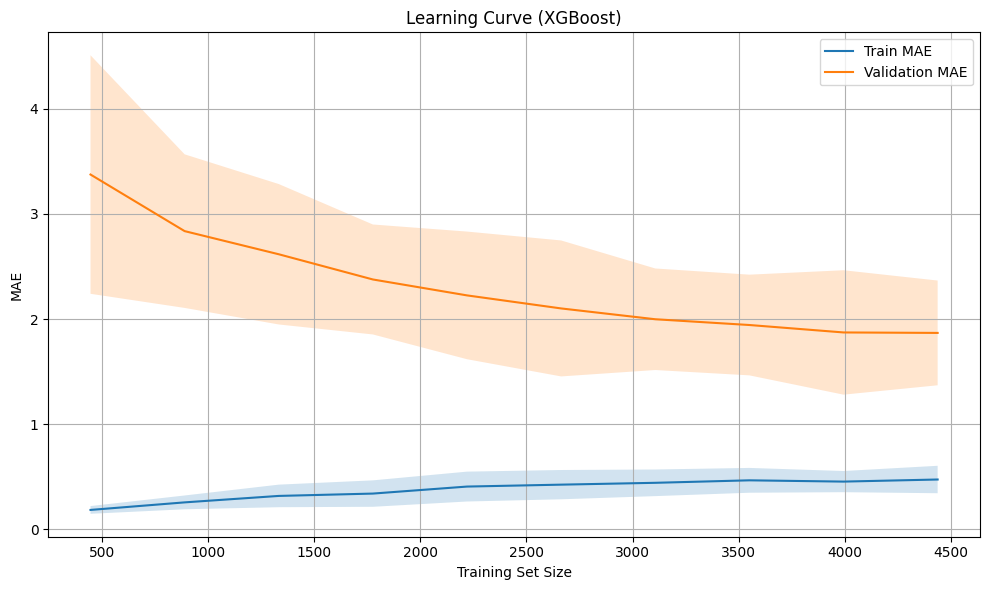

In [50]:
train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_errors, label="Train MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2)

plt.plot(train_sizes_abs, val_errors, label="Validation MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.title("Learning Curve (XGBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

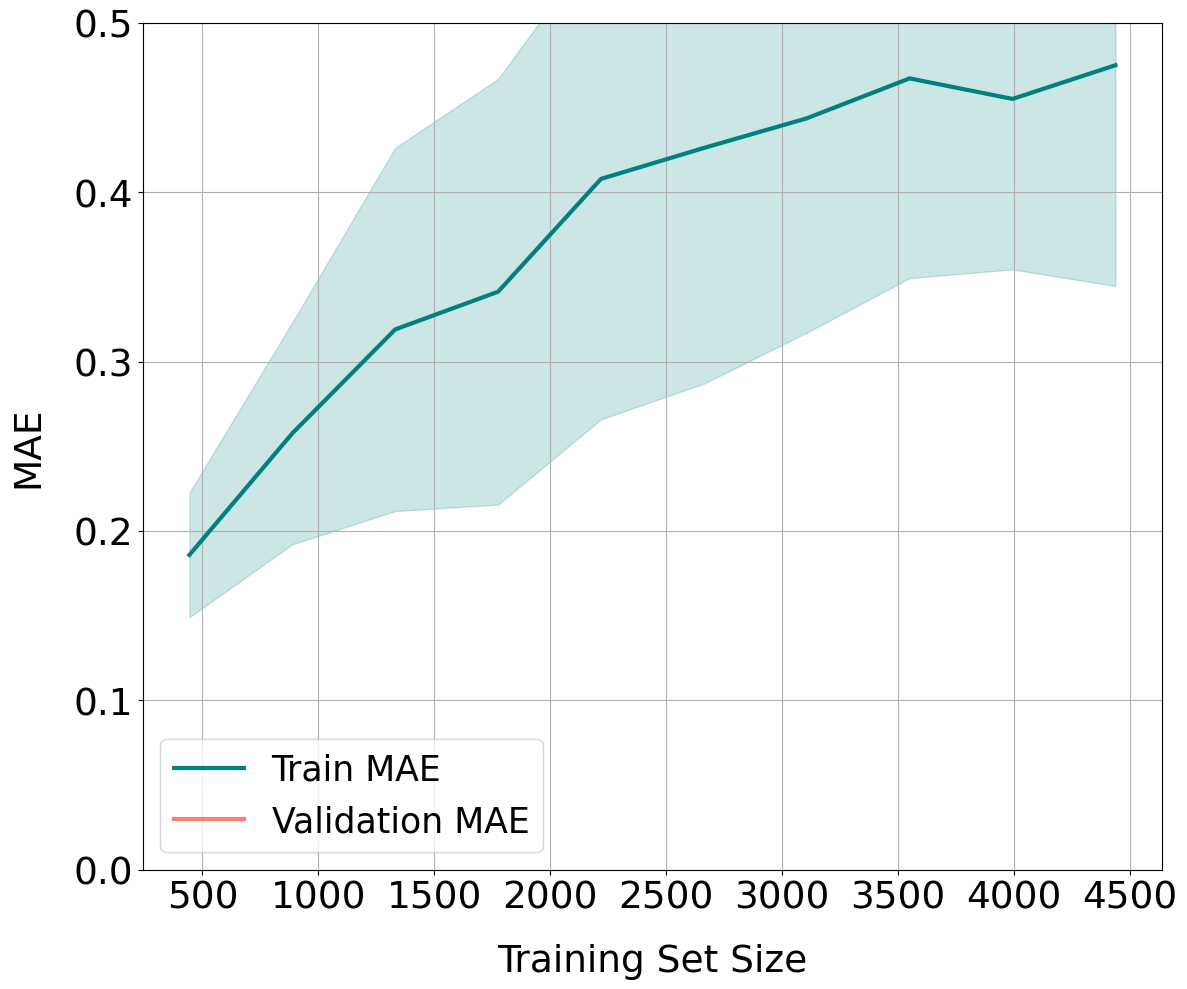

In [51]:
train_sizes_abs = train_sizes * len(X_train)

plt.figure(figsize=(12, 10))

plt.plot(train_sizes_abs, train_errors, label="Train MAE", color="teal", linewidth=3)  
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2, color="teal")

plt.plot(train_sizes_abs, val_errors, label="Validation MAE", color="salmon", linewidth=3)
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2, color="salmon")

plt.xlabel("Training Set Size", fontsize=27, labelpad=20)
plt.ylabel("MAE", fontsize=27, labelpad=20)
# plt.title("Learning Curve (Random Forest)", fontsize=16)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=25)
plt.ylim(0, 0.5)
plt.grid(True)
plt.tight_layout()
plt.show()

## Train model

In [52]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       MinMaxScaler(),
                                                                                       ['population',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'depo...
                                                                                             max_leaves=None,
                                                                                             min_child_weight=None,
                                                                                             missing=nan,
                                                                                             monotone_constraints=None,
                                                                                             multi_strategy=None,
                                                                                             n_estimators=20,
                                                                                             n_jobs=None,
                                                                                             num_parallel_tree=None,
                                                                                             random_state=123, ...),
                                                                      threshold='median')),
                                                     ('gbt',
                                                      GradientBoostingRegressor(learning_rate=0.05,
                                                                                max_depth=10,
                                                                                max_features='log2',
                                                                                min_samples_leaf=2,
                                                                                min_samples_split=8,
                                                                                n_estimators=250,
                                                                                random_state=4,
                                                                                subsample=0.8))]))

## Final Train score

In [53]:
pred_train = best_model.predict(X_train)

train_r2 = r2_score(y_train, pred_train)
train_mae = mean_absolute_error(y_train, pred_train)
train_rmse = sqrt(mean_squared_error(y_train, pred_train))

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.957921410825267
Train MAE: 0.5267490800751229
Test RMSE: 1.7645211202398714


## Final Test score

In [54]:
pred_nitrate = best_model.predict(X_test)

test_r2 = r2_score(y_test, pred_nitrate)
test_mae = mean_absolute_error(y_test, pred_nitrate)
test_rmse = sqrt(mean_squared_error(y_test, pred_nitrate))

print("Test R2:", test_r2)
print("Test MAE:", test_mae)
print("Test RMSE:", test_rmse)

Test R2: 0.5307452587196537
Test MAE: 1.8315036776744393
Test RMSE: 5.934247073411166


In [55]:
pd.Series(pred_nitrate).to_csv('test_pred_nitrate_gbt.csv', index=False)

## Real vs Predicted

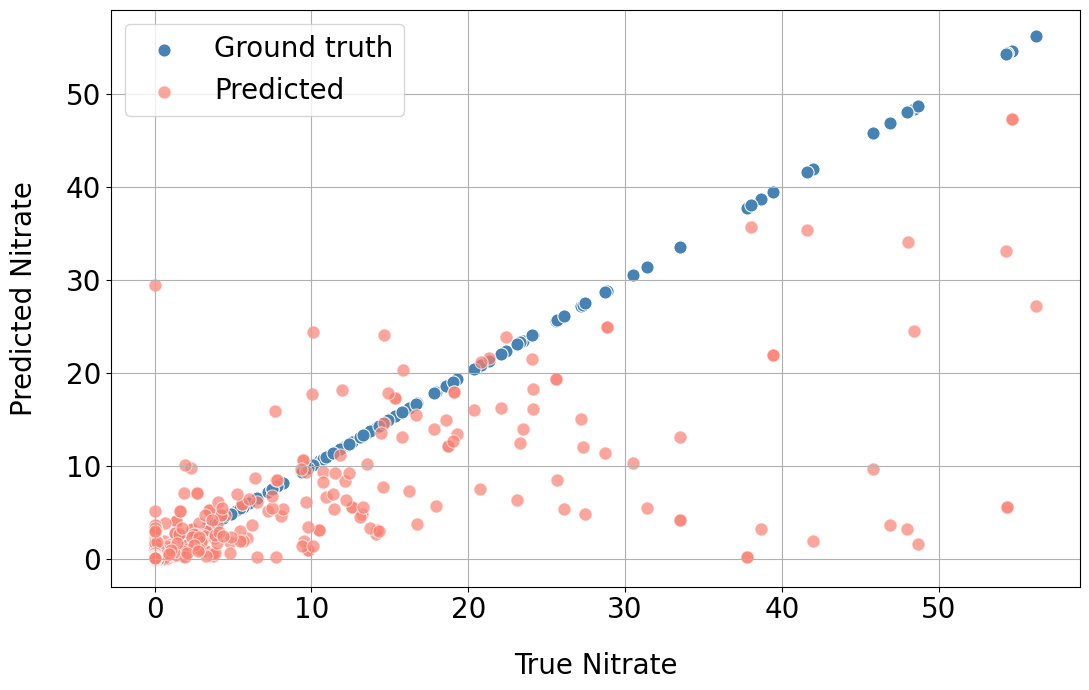

In [56]:
fig, ax = plt.subplots(figsize=(11, 7))

sns.scatterplot(x=y_test, y=y_test, ax=ax, label="Ground truth", s=90, color="steelblue")
sns.scatterplot(x=y_test, y=pred_nitrate, ax=ax, label="Predicted", s=90, color="salmon", alpha=0.7)

ax.set_xlabel("True Nitrate", fontsize=20, labelpad=20)
ax.set_ylabel("Predicted Nitrate", fontsize=20, labelpad=20)
ax.tick_params(labelsize=20)
ax.legend(fontsize=20)
ax.grid(True)

plt.tight_layout()
plt.show()


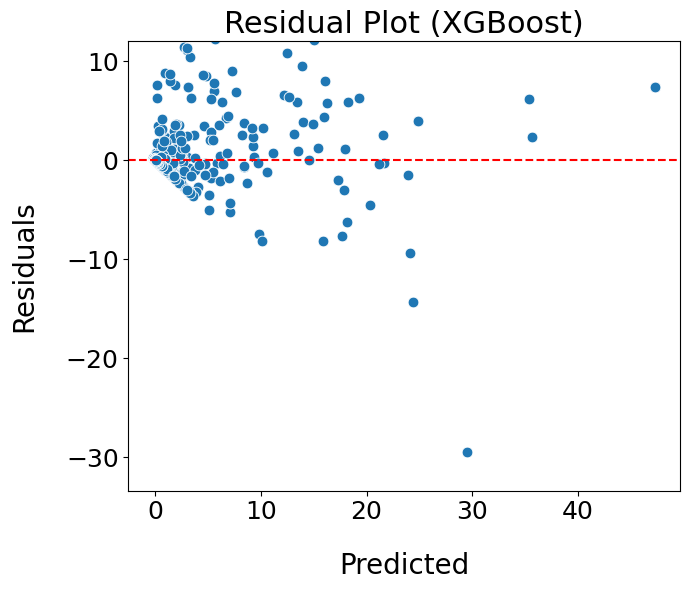

In [57]:
preds = best_model.predict(X_test)

residuals = y_test - preds
plt.figure(figsize=(7, 6))

sns.scatterplot(x=preds, y=residuals, s=60)

plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted", fontsize=20, labelpad=20)
plt.ylabel("Residuals", fontsize=20, labelpad=20)
plt.title("Residual Plot (XGBoost)", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.ylim(top=12)
plt.tight_layout()
plt.show()

In [58]:
residuals.to_csv("xgb_residuals.csv")

## Predictions on the map

In [59]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

882
882
882
882


In [60]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

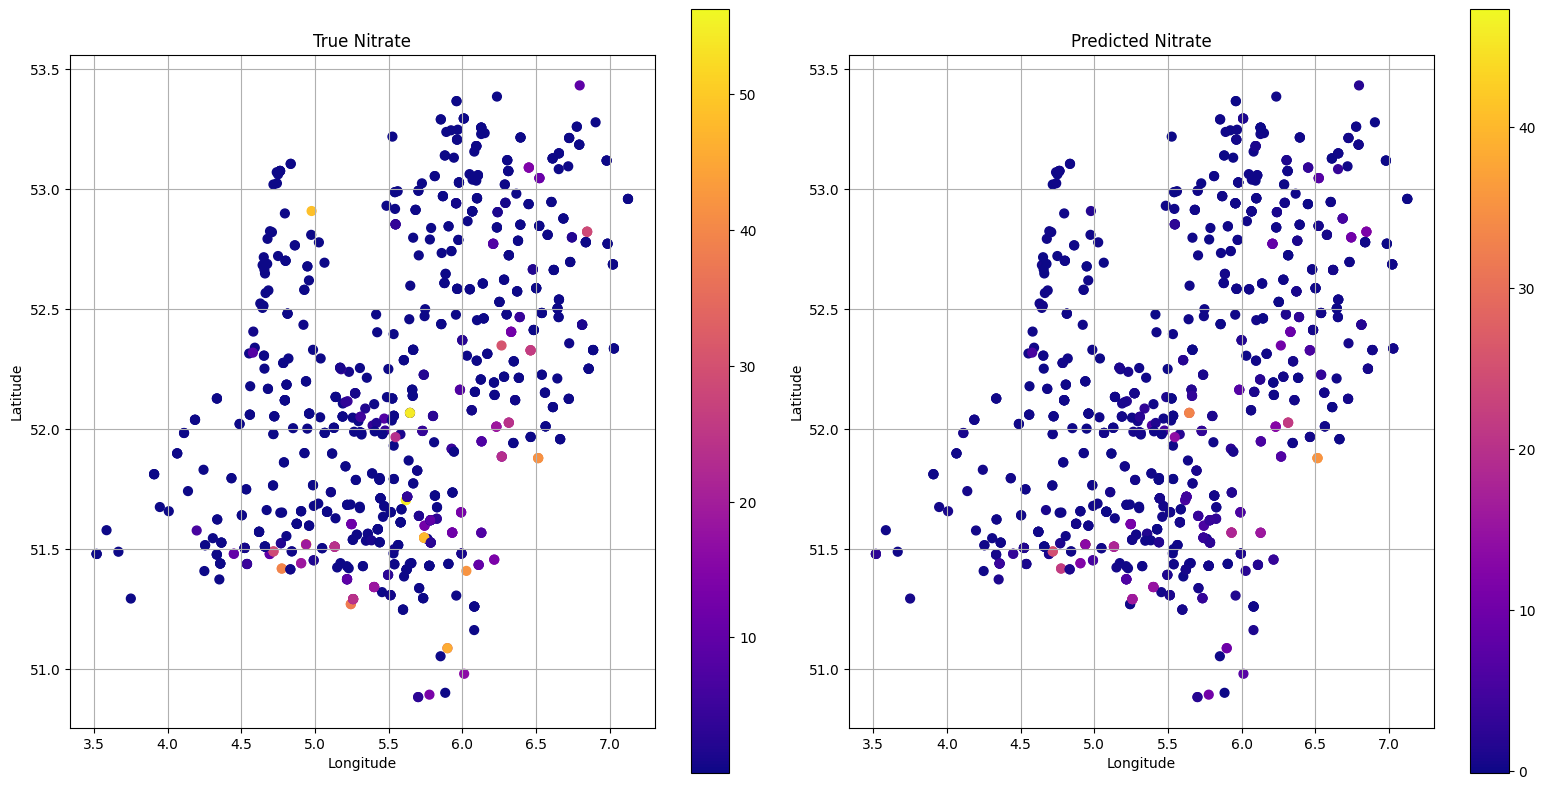

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

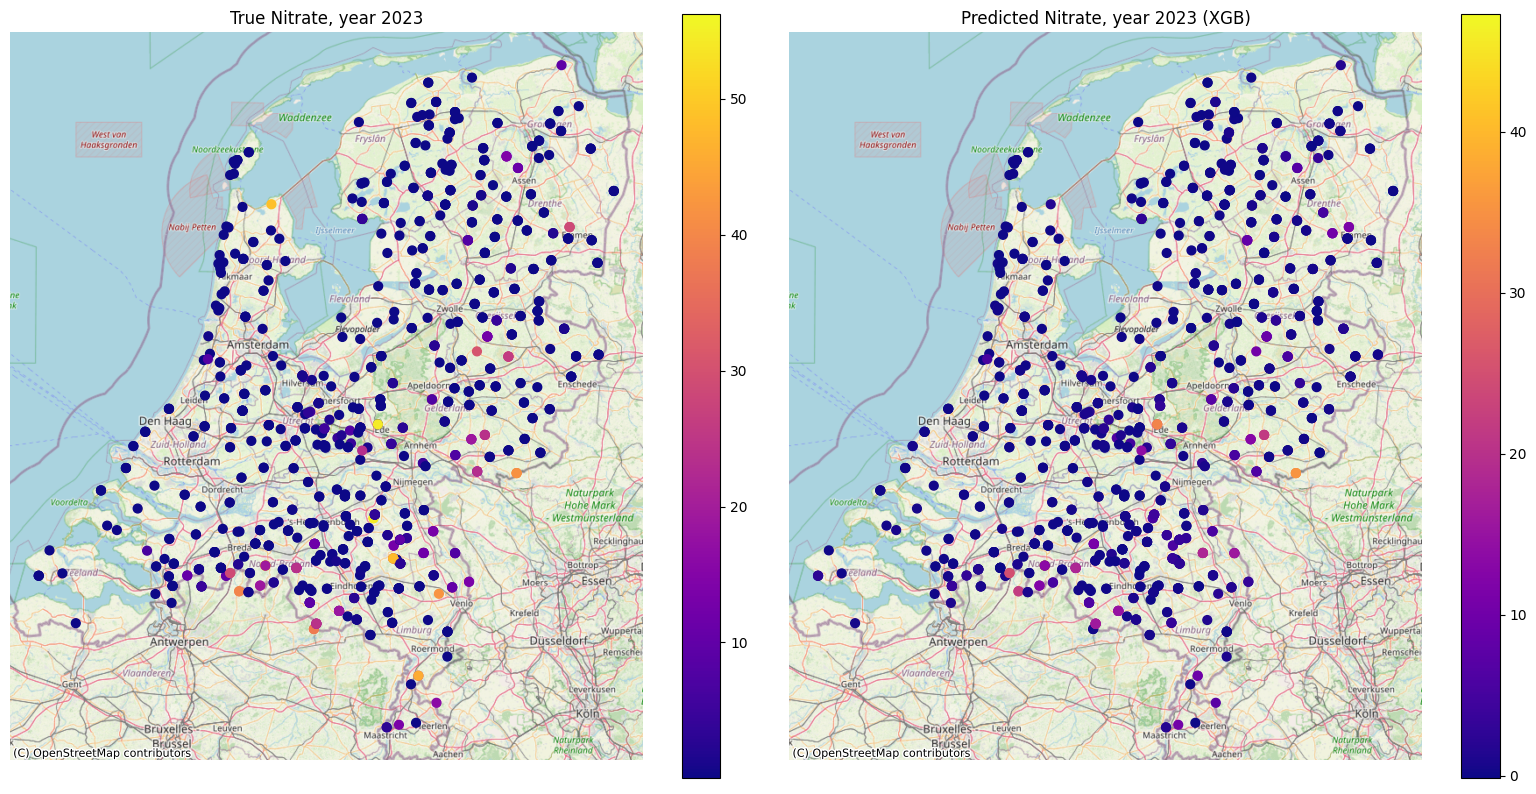

In [62]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate, year 2023")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate, year 2023 (XGB)")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

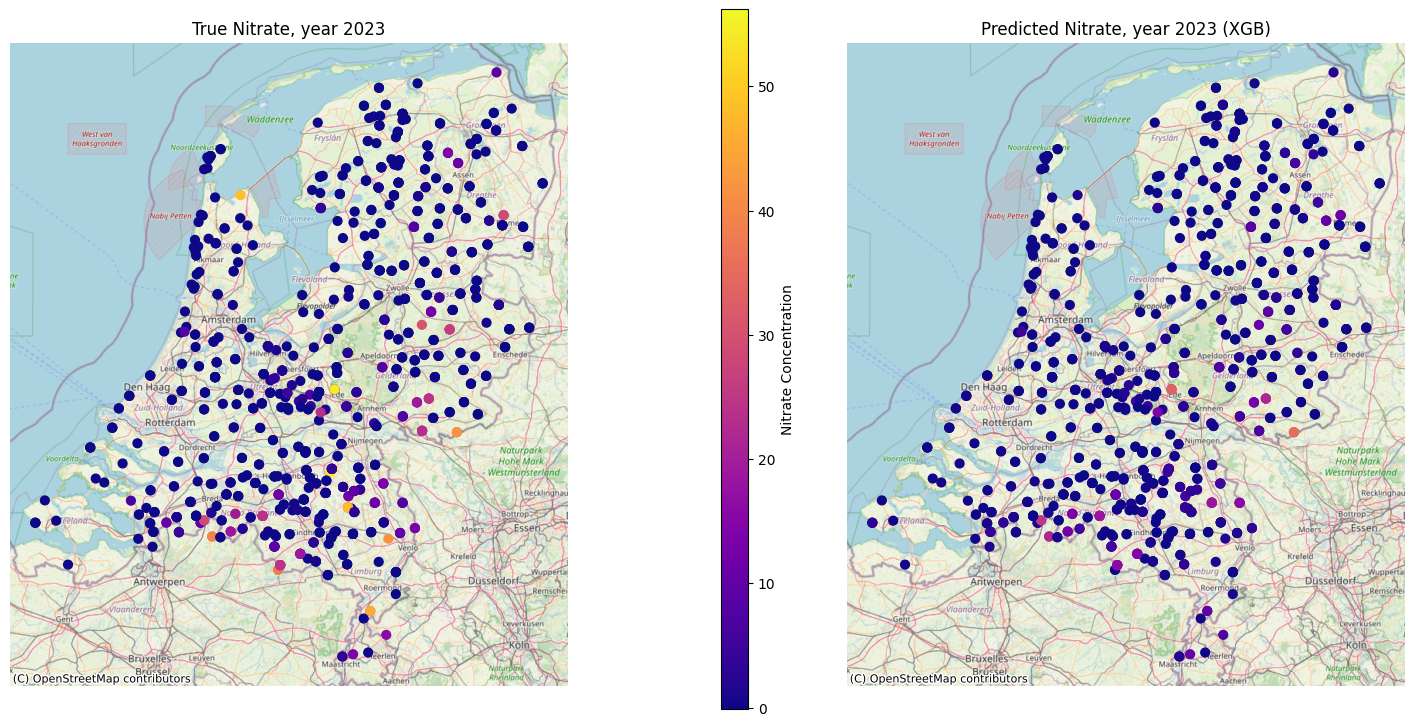

In [63]:
gdf_3857 = gdf.to_crs(epsg=3857)

vmin = min(gdf_3857["nitrate_true"].min(), gdf_3857["nitrate_pred"].min())
vmax = max(gdf_3857["nitrate_true"].max(), gdf_3857["nitrate_pred"].max())
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.plasma
sm = ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

fig, axs = plt.subplots(1, 2, figsize=(18, 10), gridspec_kw={"wspace": 0.5})

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap=cmap, norm=norm, legend=False, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate, year 2023")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap=cmap, norm=norm, legend=False, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate, year 2023 (XGB)")

for ax in axs:
    ax.set_axis_off()

cbar_ax = fig.add_axes([0.52, 0.15, 0.015, 0.7])
fig.colorbar(sm, cax=cbar_ax, label="Nitrate Concentration")

plt.show()


## Logging

In [64]:
curr_dir = os.getcwd()
log_path = os.path.join(curr_dir, '../../logging/experiment_log.json')

# After each notebook run, do this!
logger = ExperimentLogger(save_path=log_path)

# if not outlier_method:

model = "Boosted Regression Tree"
hyperparams = search.best_params_
outlier_method = outlier_method
train_score = {"R2": train_r2, "MAE": train_mae, "RMSE": train_rmse}
test_score = {"R2": test_r2, "MAE": test_mae, "RMSE": test_rmse}
data_file_name = data_path

logger.log(
    model = model,
    data_file = data_file_name,
    features = number_of_features,
    hyperparams=hyperparams,
    outlier_method=outlier_method,
    train_score=train_score,
    test_score=test_score,
    extra_info={"note": "Removed soil region"}
)

{'model': 'Boosted Regression Tree',
 'data_file': '/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/notebooks/models/../../data/aligned/merged_dataset_1_ahn_elevation.csv',
 'features': 20,
 'timestamp': '2025-07-13T13:07:59.453983',
 'hyperparameters': {'regressor__gbt__subsample': 0.8,
  'regressor__gbt__n_estimators': 250,
  'regressor__gbt__min_samples_split': 8,
  'regressor__gbt__min_samples_leaf': 2,
  'regressor__gbt__max_features': 'log2',
  'regressor__gbt__max_depth': 10,
  'regressor__gbt__learning_rate': 0.05},
 'outlier_method': 'manual_removal',
 'train_score': {'R2': 0.957921410825267,
  'MAE': 0.5267490800751229,
  'RMSE': 1.7645211202398714},
 'test_score': {'R2': 0.5307452587196537,
  'MAE': 1.8315036776744393,
  'RMSE': 5.934247073411166},
 'note': 'Removed soil region'}

## Interpretability

In [65]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['landuse '
                                                                                        'code',
                                                                                        'mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       MinMaxScaler(),
                                                                                       ['population',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        'n '
                                                                                        'depo...
                                                                                             max_leaves=None,
                                                                                             min_child_weight=None,
                                                                                             missing=nan,
                                                                                             monotone_constraints=None,
                                                                                             multi_strategy=None,
                                                                                             n_estimators=20,
                                                                                             n_jobs=None,
                                                                                             num_parallel_tree=None,
                                                                                             random_state=123, ...),
                                                                      threshold='median')),
                                                     ('gbt',
                                                      GradientBoostingRegressor(learning_rate=0.05,
                                                                                max_depth=10,
                                                                                max_features='log2',
                                                                                min_samples_leaf=2,
                                                                                min_samples_split=8,
                                                                                n_estimators=250,
                                                                                random_state=4,
                                                                                subsample=0.8))]))

In [66]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [ ]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['xgb']

feature_names = fitted_preprocessor.get_feature_names_out()

### Default interpretability: Gain

In [1566]:
importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

                                              feature  importance
61                       num_scaler__minimumacidity_1    0.060773
60                              num_scaler__acidity_1    0.056133
62                       num_scaler__maximumacidity_1    0.046812
36                         cat_ohe__landuse code_61.0    0.046308
54                              num_scaler__elevation    0.030269
..                                                ...         ...
29                         cat_ohe__landuse code_40.0    0.000000
28                         cat_ohe__landuse code_39.0    0.000000
3                           cat_ohe__landuse code_4.0    0.000000
23                         cat_ohe__landuse code_34.0    0.000000
52  cat_ohe__mainsoilclassification_1_Zeer oude ma...    0.000000

[68 rows x 2 columns]


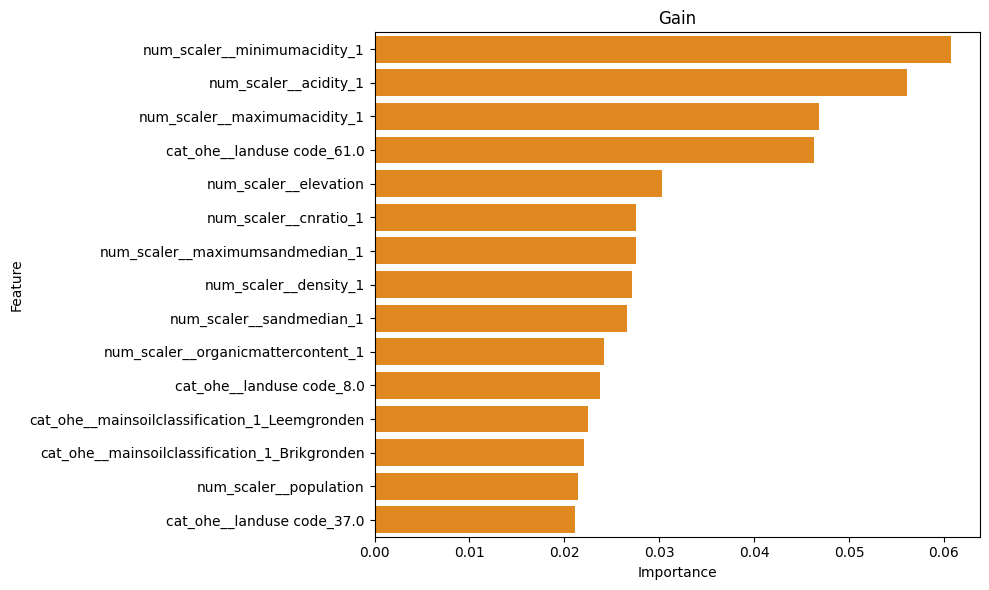

In [1567]:
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), color="darkorange")
plt.title("Gain")
plt.tight_layout()
plt.show()

In [1568]:
booster = fitted_model.get_booster()

feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}

# importance_types = ["gain", "cover", "weight"]
importance_types = ["gain"]
importance_data = []

for imp_type in importance_types:
    imp_dict = booster.get_score(importance_type=imp_type)
    for fx, val in imp_dict.items():
        importance_data.append({
            "Feature": feature_map.get(fx, fx), #here we map f1, f2, etc with real feature names
            "Importance": val,
            "Type": imp_type
        })

In [1569]:
# convert list of dictionaries to pandas df
importances_df = pd.DataFrame(importance_data)

# normalize the feature importances within each importance type
# divide every value in that group by the total sum of the group
# so it always ranges between (0 - 1)
importances_df["Importance"] = importances_df.groupby("Type")["Importance"].transform(lambda x: x / x.sum())

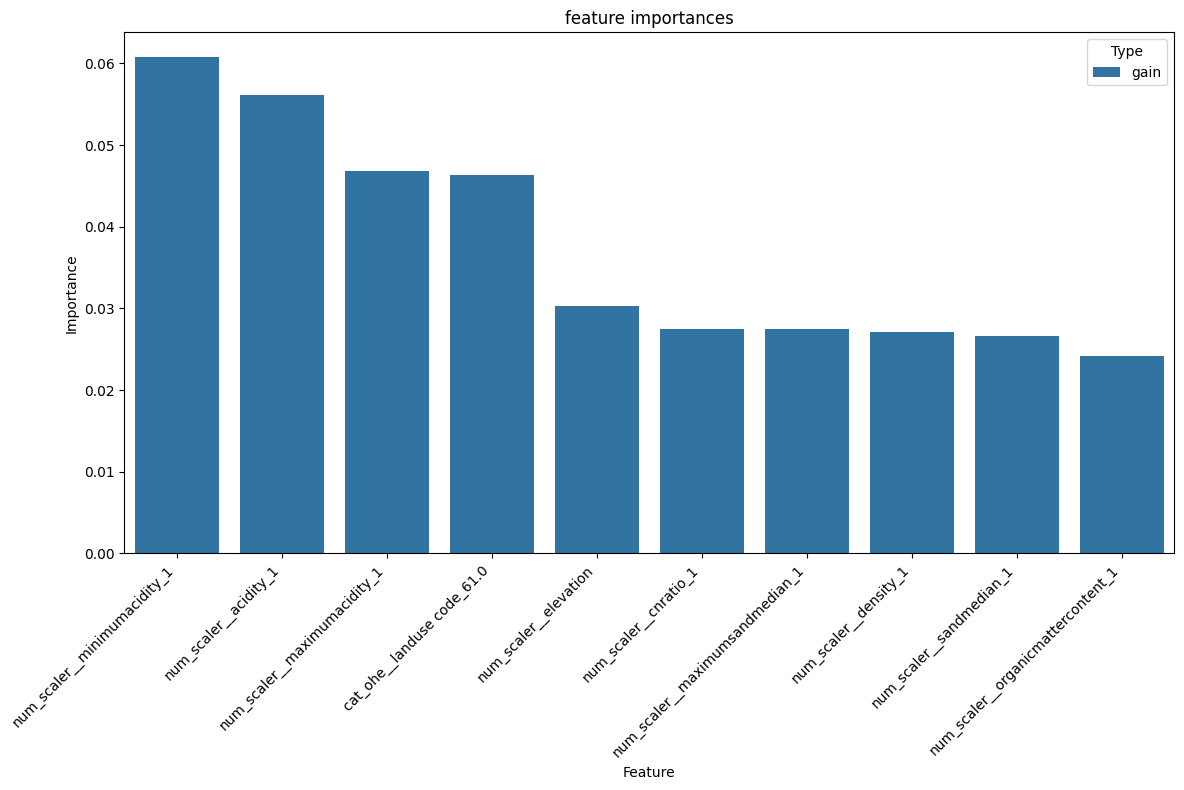

In [1570]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("feature importances")
plt.tight_layout()
plt.show()


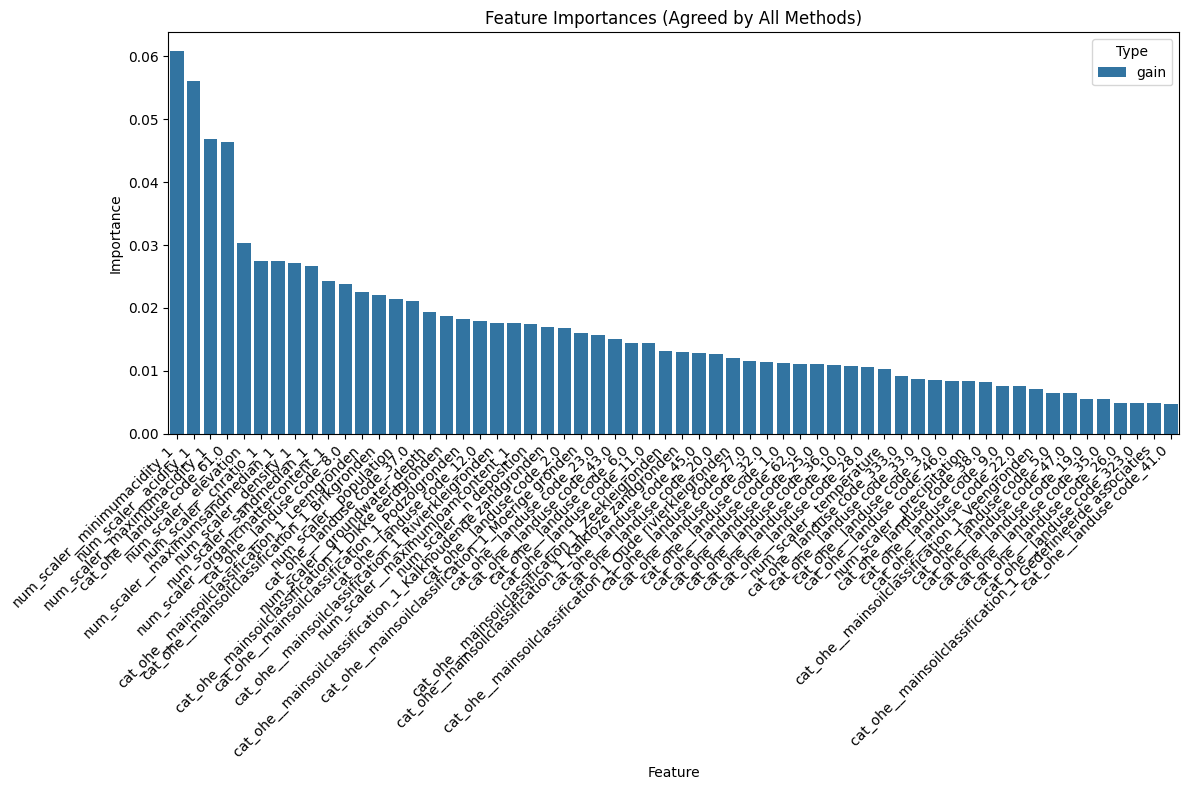

In [1571]:
methods = importances_df["Type"].unique()

feature_method_counts = (
    importances_df.groupby("Feature")["Type"]
    .nunique()
    .reset_index(name="method_count")
)

consistent_features = feature_method_counts[
    feature_method_counts["method_count"] == len(methods)
]["Feature"]

consistent_df = importances_df[importances_df["Feature"].isin(consistent_features)]

plt.figure(figsize=(12, 8))
sns.barplot(
    data=consistent_df.sort_values("Importance", ascending=False),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importances (Agreed by All Methods)")
plt.tight_layout()
plt.show()


# Model-agnostic interpretability

In [1572]:
assert fitted_model.n_features_in_ == len(feature_names)

In [1573]:
X_test_transformed = fitted_preprocessor.transform(X_test)
y_test_true = y_test

## Permutation

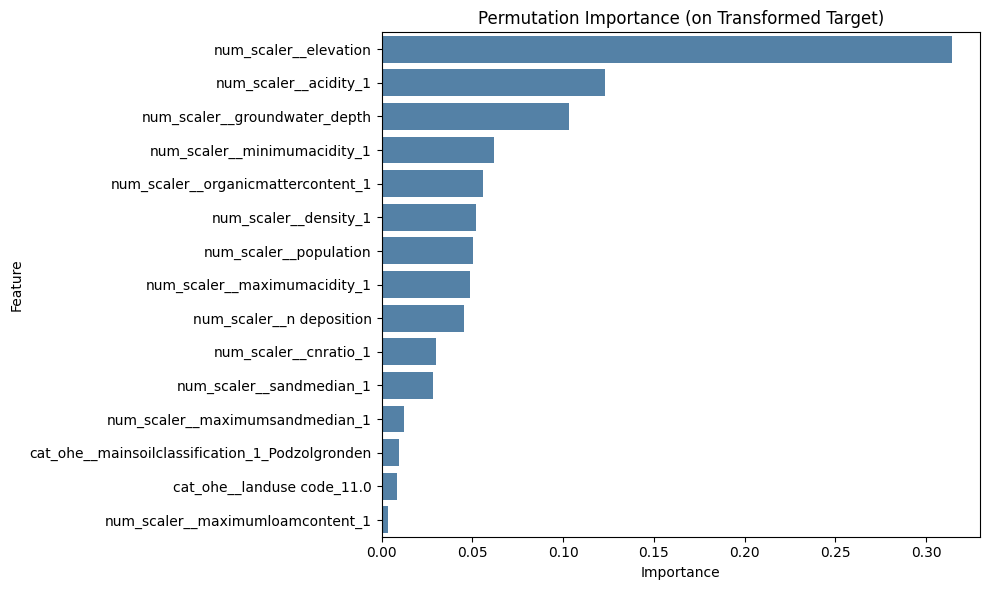

In [1574]:
if isinstance(best_model, TransformedTargetRegressor):
    y_test_true = np.log1p(y_test)

perm_result = permutation_importance(
    fitted_model, 
    X_test_transformed, 
    y_test_true,
    n_repeats=10,
    random_state=42,
    scoring="r2"
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean,
    "Std": perm_result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=perm_df.head(15), color="steelblue")
plt.title("Permutation Importance (on Transformed Target)")
plt.tight_layout()
plt.show()


In [1575]:
perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"

combined_df = pd.concat([importances_df, perm_df], axis=0)

In [1576]:
combined_df

,Feature,Importance,Type,Std
0,cat_ohe__landuse code_1.0,0.011326,gain,NaN
1,cat_ohe__landuse code_2.0,0.016844,gain,NaN
2,cat_ohe__landuse code_3.0,0.008549,gain,NaN
3,cat_ohe__landuse code_5.0,0.006496,gain,NaN
4,cat_ohe__landuse code_6.0,0.014415,gain,NaN
...,...,...,...,...
46,cat_ohe__mainsoilclassification_1_Moerige gronden,-0.000021,permutation,0.000091
43,cat_ohe__mainsoilclassification_1_Kalkhoudende...,-0.000371,permutation,0.000060
55,num_scaler__precipitation,-0.000972,permutation,0.001757
33,cat_ohe__landuse code_45.0,-0.001225,permutation,0.000808


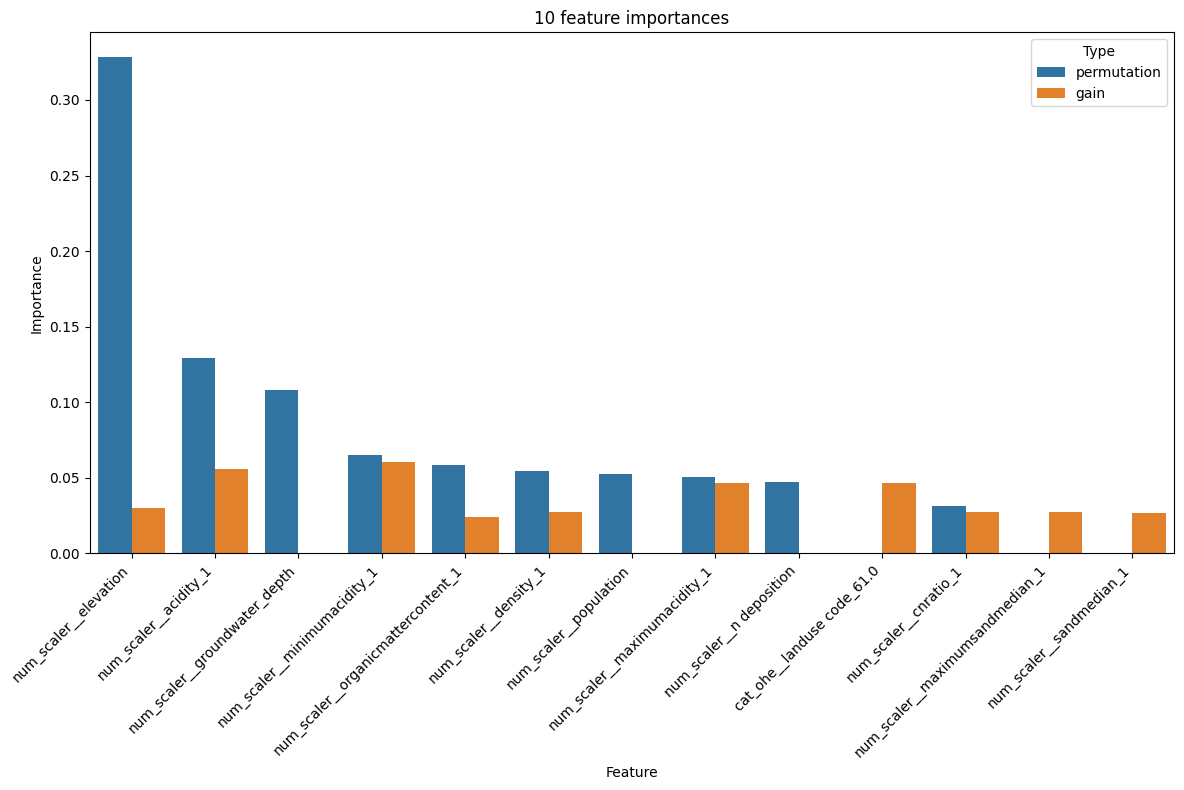

In [1577]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("10 feature importances")
plt.tight_layout()
plt.show()

## Tree SHAP

In [ ]:
X_test_transformed = fitted_preprocessor.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

explainer = shap.TreeExplainer(fitted_model)

shap_values = explainer(X_test_transformed)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_transformed_df.values,
    feature_names=X_test_transformed_df.columns
)

shap.plots.bar(shap_explanation, max_display=15)


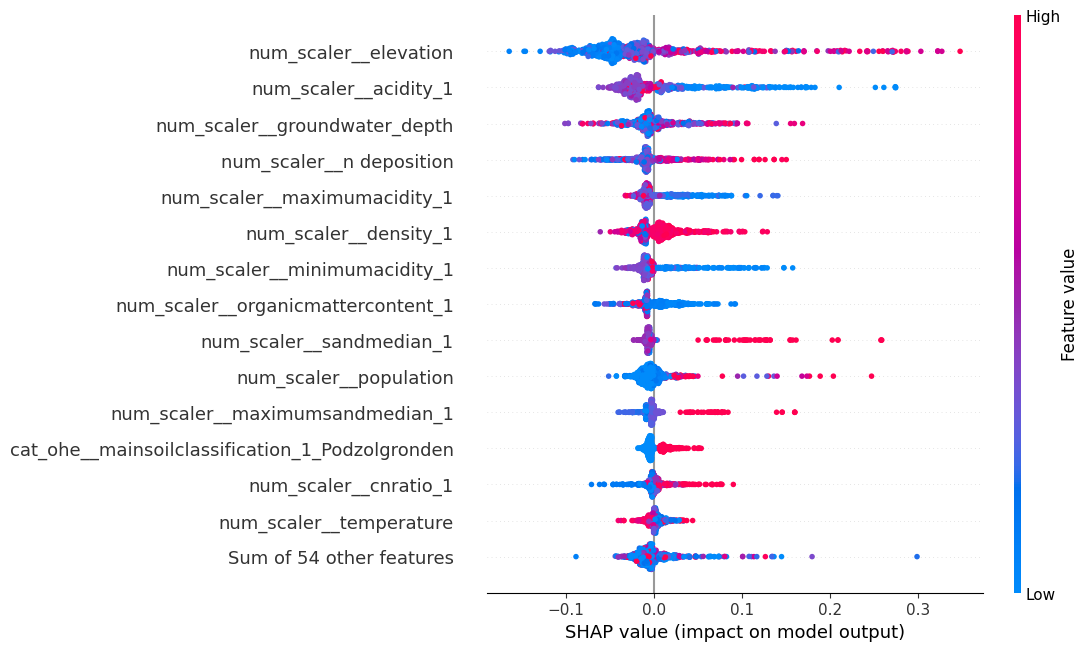

In [1579]:
shap.plots.beeswarm(shap_explanation, max_display=15)

In [1580]:
shap_mean_importance = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": shap_mean_importance
}).sort_values("Importance", ascending=False)

shap_df["Importance"] /= shap_df["Importance"].sum()
shap_df["Type"] = "shap"


In [1581]:
perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean
}).sort_values("Importance", ascending=False)

perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"


In [1582]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(
    X_test_transformed_df.values,
    feature_names=feature_names,
    mode='regression',
    random_state=4
)

lime_weights = np.zeros(len(feature_names))
n_samples = 30

for i in range(n_samples):
    explanation = lime_explainer.explain_instance(
        X_test_transformed_df.values[i],
        fitted_model.predict,
        num_features=len(feature_names)
    )
    
    for feature_str, weight in explanation.as_list():
        for j, fname in enumerate(feature_names):
            if fname in feature_str:
                lime_weights[j] += abs(weight)
                break  # stop at first match


lime_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": lime_weights / lime_weights.sum(),
    "Type": "lime"
})

In [1583]:
combined_df = pd.concat([shap_df, perm_df, lime_df], ignore_index=True)
combined_df.to_csv("model-agnostic.csv")

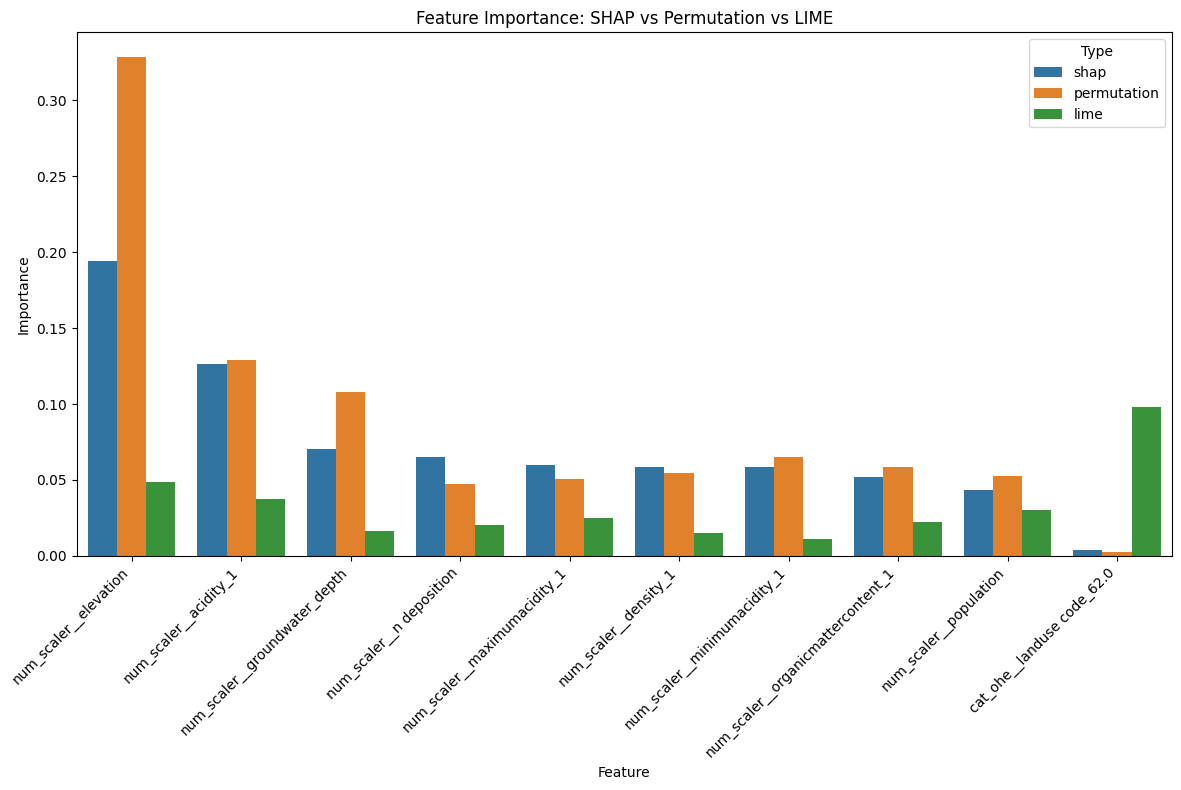

In [1584]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df[combined_df["Feature"].isin(
        combined_df.groupby("Feature")["Importance"].sum().nlargest(10).index
    )],
    x="Feature", y="Importance", hue="Type"
)
plt.xticks(rotation=45, ha="right")
plt.title("Feature Importance: SHAP vs Permutation vs LIME")
plt.tight_layout()
plt.show()
